In [1]:
%load_ext autoreload
%autoreload 2

## Рекомендуем видео с учетом итересов пользователей

Вы - разработчик рекомендательной системы в онлайн-кинотеатре. Пользователи, заходя на главную страницу, видят 20 рекомендуемых коротких видео и выбирают понравившиеся. Мы изучили их предпочтения и выяснили, что пользователи часто выбирают видео любимых жанров/тем. Вам нужно обучить рекомендательную модель, которая сможет выявить предпочтения пользователей. У вас нет исторических данных, но доступен симулятор, генерирующий отклики пользователей на рекомендации, который поможет получить данные в интерактивном режиме.


### Пользователи
1000 анонимных пользователей

### Фильмы
1000 видео и информация об их жанрах/темах

### Модель отклика пользователя на товары
Пользователь выбирает видео любимых жанров/тем. Пользователи смотрят видео только из рекомендаций и могут просматривать те же самые видео при повторном посещении сервиса.

### Задача
Построить рекомендательную систему, которая обеспечит наибольшее количество просмотров видео на пользователя

### Доступные данные
Пользователи будут реагировать на ваши рекомендации в интерактивном режиме. Вы получаете список пользователей, для каждого из которых нужно подготовить по 20 рекомендаций. Симулятор генерирует отклики на рекомендации, которые вы можете использовать для обучения рекомендательной системы.

## Симулятор
Детальную информацию о симуляторе смотри в ноутбуке к заданию 1.

## Импорты и настройки

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [2]:
import random
import time
import tqdm

import pandas as pd
import numpy as np

import pyspark.sql.functions as sf
from pyspark import SparkConf
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
from surprise import SVD, Dataset, Reader, SVDpp, KNNBaseline, SlopeOne, NMF

from replay.models import UCB
from replay.session_handler import State
from replay.utils import get_top_k_recs


# укажите путь к tmp-папке spark и директории с чекпоинтами симулятора.
SPARK_LOCAL_DIR = './tmp/task_2_av'
CHECKPOINT_DIR = './tmp/task_2_av_checkpoints'

In [3]:
from simulator.modules import RealDataGenerator
from simulator.modules import Simulator

from helpers.task_2 import TaskTwoResponse
from helpers.utils import plot_metric, calc_metric

In [4]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1 $2

In [5]:
# если вы не работали со Spark ранее, оставьте настройки сессии неизменными
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)
spark.sparkContext.setLogLevel('ERROR')

22/12/03 07:15:23 WARN Utils: Your hostname, cl1nr5sb14mq6gk2g9m8-ybuc resolves to a loopback address: 127.0.1.1; using 10.129.0.36 instead (on interface eth0)
22/12/03 07:15:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/03 07:15:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/03 07:15:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/12/03 07:15:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/03 07:15:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:
NUM_USERS = 1000
NUM_ITEMS = 1000
# число рекомендаций, генерируемых рекомендательной системой на пользователя на одной итерации
K = 20
# количество итераций
NUM_ITER = 50
SEED = 1234

## Исходные данные

В нашем распоряжении есть id пользователей и товаров.

In [7]:
users = spark.read.parquet('data/task_2_data/user_idx.parquet').withColumn("user_idx", sf.col("user_idx").cast("int"))
items = spark.read.parquet('data/task_2_data/item_idx.parquet').withColumn("item_idx", sf.col("item_idx").cast("int"))
items.show(2)

+--------+
|item_idx|
+--------+
|       0|
|       1|
+--------+
only showing top 2 rows



## Модель отклика

Модель отклика пользователей на товары в этой задаче является очень простой. Отклик зависит от того, насколько интересы пользователя совпадают с содержанием видео. Модель отклика пользователя не меняется со временем, т.е. просмотренные в ходе симуляции видео не влияют на его интересы, но сам факт положительного отклика на данной итерации - случайная величина. 

Модель отклика принимает датафрейм с колонками <user_idx, item_idx, relevance>, где relevance - оценка релевантности рекомендательной системы и возвращает датафрейм с обязательными колонками <user_idx, item_idx, relevance, response>, добавляя к исходным данным столбец с откликами (response). Если в датафрейме, поданном на вход в модель отклика, были признаки, они также будут возвращены.

In [8]:
topic_model = TaskTwoResponse(spark)

Посмотрим на примере, как формируется отклик для пар:

In [9]:
topic_model.transform(users.limit(1).crossJoin(items.limit(2)).withColumn("relevance", sf.lit(1.))).show()

+--------+--------+---------+--------+
|item_idx|user_idx|relevance|response|
+--------+--------+---------+--------+
|       0|       0|      1.0|       0|
|       1|       0|      1.0|       1|
+--------+--------+---------+--------+



Модель отклика должна возвращать отклики на рекомендации в виде spark dataframe с обязательными колонками <user_idx, item_idx, relevance, response>,
где response - сгенерированный отклик, а остальные колонки соотвествуют переданным.

# Обучение модели в симуляторе

Перейдем непосредственно к циклу симуляции. Инициализируем симулятор и все нужные для симуляции модели. Обратите внимание, что если вы захотите перезапустить эксперимент, нужно будет выбрать другую папку для сохранения данных `data_dir` или удалить с диска результаты предыдущего эксперимента. Либо вы можете продолжить эксперимент с новой итерации (например, последней была выполнена 10 итерация, значит цикл нужно продолжить с 11-ой). 

Запустите ячейки ниже последовательно, чтобы начать новый эксперимент.

## Инциализируем компоненты симулятора

In [10]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

# передадим популяции пользователей и айтемов
item_generator.fit(items)
user_generator.fit(users)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: int]

In [11]:
user_generator.sample(0.01).show(2)

+--------+
|user_idx|
+--------+
|     607|
|     894|
+--------+
only showing top 2 rows



In [23]:
%%bash -s "$CHECKPOINT_DIR"
# симулятор записывает историю взаимодействия пользователей с рекомендательной системой на диск
# чтобы перезапустить цикл симуляции или начать новый, очистите директорию или используйте другую в качестве CHECKPOINT_DIR
rm -rf $1

In [24]:
sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class SVDRL:
    def __init__(self):
        #self.model = SVDpp(n_factors=20, n_epochs=20)
        self.models = [(KNNBaseline(k=40), 0.5), (SVDpp(n_factors=20, n_epochs=20), 0.3), (SVD(), 0.2)]
        #self.model = NMF(n_factors=20, n_epochs=20)
        self.ucb = UCB(sample=True, seed=SEED)
        self.scaler = MinMaxScaler()
        
    def fit(self, log=None):
        self.ucb.fit(log)
        log = log.toPandas()
        reader = Reader(rating_scale=(0, 1))
        data = Dataset.load_from_df(log[["user_idx", "item_idx", "relevance"]], reader)
        trainset = data.build_full_trainset()
        for e in range(3):
            self.models[e][0].fit(trainset)
        #self.model.fit(trainset)
        
    def predict(self, log=None, k=None, users=None, items=None, filter_seen_items=None):
        result = []
        recs = self.ucb.predict(
            log=log,
            k=items.count(),
            users=users,
            items=items,
            filter_seen_items=False
        ).cache()
        recs = recs.toPandas().sort_values(by=['user_idx', 'item_idx'])
        recs['relevance'] = self.scaler.fit_transform(np.array(recs['relevance']).reshape(-1, 1)).reshape(-1)
        it_ = 0
        for u in sorted(users.toPandas()['user_idx']):
            buffer = []
            for i in sorted(items.toPandas()['item_idx']):
                score = sum([model[0].predict(u, i).est * model[1] for model in self.models]) + recs.iloc[it_]['relevance'] * 0.1
                it_ += 1
                buffer.append((u, i, score))
            buffer.sort(key=lambda x: -x[2])
            result.extend(buffer[:k])
        return spark.createDataFrame(pd.DataFrame(result, columns=['user_idx', 'item_idx', 'relevance']))

## Инициализация вашей рекомендательной модели

In [26]:
### YOUR CODE HERE: инициализация модели. Замените код бейзлайна на ваш код

# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
# model = UCB(exploration_coef=0.1, sample=True, seed=SEED)
# model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))
model = SVDRL()
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))
###

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


### Проверка формата рекомендаций моделью

In [27]:
### YOUR CODE HERE: получите K уникальных рекомендаций для 10 пользователей 
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)
###

# проверьте правильность формирования рекомендаций
assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert pred.groupBy('user_idx').agg(sf.countDistinct("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10
assert pred.groupBy('user_idx').agg(sf.count("item_idx").alias("num_items")).filter(sf.col("num_items") == sf.lit(K)).count() == 10

## Цикл симуляции

Модель UCB не является персонализированной, поэтому довольно плохо подходит для задачи предсказания персонализированной модели отклика, основанной на тематических интересах. Она дана вам в качестве бейзлайна. Надеемся, у вас получится подобрать более подходящую модель. 

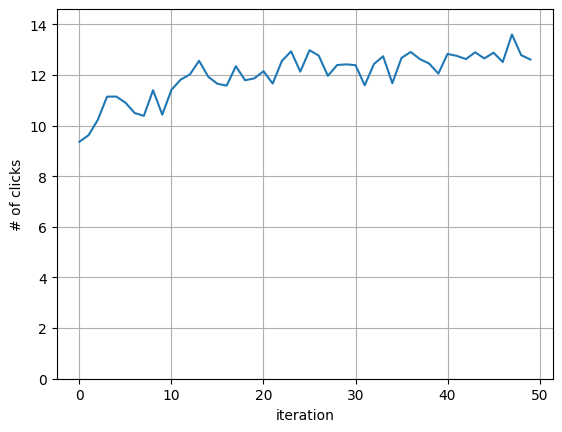

Iteration 49 finished in 80.69743728637695 sec.


In [28]:
metrics = []
for i in range(NUM_ITER):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(current_users)


    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    recs = model.predict(
        log=log,
        k=K,
        users=current_users,
        items=items,
        filter_seen_items=False
    ).cache()
    ###

    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )

    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=topic_model
    ).cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)

    # оцениваем качество
    metrics.append(calc_metric(true_resp))
    
    
    ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    model.ucb._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

In [276]:
train_log.toPandas()

,item_idx,user_idx,relevance,response,__iter
0,139,695,0.831683,1,23
1,137,695,0.823383,1,23
2,100,695,0.764179,1,23
3,72,695,0.736632,1,23
4,71,695,0.712018,0,23
...,...,...,...,...,...
10115,105,67,0.696145,0,12
10116,74,67,0.685117,1,12
10117,70,67,0.682521,1,12
10118,80,67,0.680742,0,12


## Финальный результат

In [29]:
### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users

recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

Сохраните ноутбук, ячейки в котором выполнены последовательно. Результаты из ячейки ниже будут использоваться для оценки решения команды. Свою модель приложите к ноутбуку в виде py-файла и импортируйте модель из него для всех трех заданий. 

In [30]:
# получаем отклики на рекомендации
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=topic_model
).cache()

# оцениваем качество
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

Среднее число купленных товаров на пользователя после обучения модели = 12.79


In [117]:
train_log.toPandas().sort_values(by=['__iter'], ascending=False)

,item_idx,user_idx,relevance,response,__iter
8479,21,407,0.764032,1,49
8104,17,361,0.609152,1,49
8114,95,422,0.623386,1,49
8113,70,422,0.644729,0,49
8112,17,422,0.678140,1,49
...,...,...,...,...,...
8317,0,445,1.000000,0,0
8316,19,842,1.000000,0,0
8315,18,842,1.000000,1,0
8314,17,842,1.000000,0,0
